In [ ]:
# !pip install h5py

In [1]:
# импорт нужных библиотек и модулей

import numpy as np
import h5py
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [2]:
# список всех модуляций из датасета в правильном порядке

modulation_labels = ['OOK', '4ASK', '8ASK', 'BPSK', 'QPSK', '8PSK', '16PSK', '32PSK', 
                    '16APSK', '32APSK', '64APSK', '128APSK', '16QAM', '32QAM', '64QAM',
                    '128QAM', '256QAM', 'AM-SSB-WC', 'AM-SSB-SC', 'AM-DSB-WC', 'AM-DSB-SC',
                    'FM', 'GMSK', 'OQPSK']

In [3]:
# так как стоит конкретная задача - восстановление сигнала с БПЛА, 
# то выберем подходящие модуляции

selected_modulations = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM"]

selected_indices = [modulation_labels.index(mod) for mod in selected_modulations]

selected_indices

[3, 4, 5, 12, 14]

In [4]:
# Открываем файл

file_path = '/kaggle/input/radioml2018/GOLD_XYZ_OSC.0001_1024.hdf5'

filtered_signals = []

with h5py.File(file_path, 'r') as f:
    labels = f['Y']  # Метки в формате one-hot
    for i in range(labels.shape[0]):  
        label = np.argmax(labels[i])  # Преобразуем one-hot в индекс модуляции
        if label in selected_indices:
            filtered_signals.append(f['X'][i])  

filtered_signals = np.array(filtered_signals)

In [5]:
# Проверка доступности GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Found GPU: {gpus[0].name}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")

# Указываем устройство
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    

    # Нормализация данных
    filtered_signals = (filtered_signals - np.min(filtered_signals)) / (np.max(filtered_signals) - np.min(filtered_signals))
    
    # Разделение на тренировочную и тестовую выборки
    X_train, X_test = train_test_split(filtered_signals, test_size=0.2, random_state=42)
    
    latent_dim = 64  # Размерность латентного пространства
    
    # Энкодер
    def build_encoder(input_shape):
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.Flatten()(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        return Model(inputs, [z_mean, z_log_var], name="encoder")
    
    # Репараметризация
    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            epsilon = tf.random.normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def build_decoder(output_shape):
        latent_inputs = layers.Input(shape=(latent_dim,))
        x = layers.Dense(np.prod(output_shape) // 2, activation='relu')(latent_inputs)  # Уменьшите размерность, чтобы компенсировать Upsampling
        x = layers.Reshape((output_shape[0] // 2, output_shape[1]))(x)  # Восстановите половину временной размерности
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
        outputs = layers.Conv1D(2, 3, activation='sigmoid', padding='same')(x)  # Измените последний слой на 2 канала
        return Model(latent_inputs, outputs, name="decoder")
    
    # Построение VAE
    input_shape = X_train.shape[1:]
    encoder = build_encoder(input_shape)
    decoder = build_decoder(input_shape)
    
    inputs = layers.Input(shape=input_shape)
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    outputs = decoder(z)
    
    vae = Model(inputs, outputs, name="vae")

    # Слой для KL-дивергенции
    class KLDivergenceLayer(Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            self.add_loss(tf.reduce_mean(kl_loss))
            return inputs
    
    # Добавляем слой KL-дивергенции
    _ = KLDivergenceLayer()([z_mean, z_log_var])

        # Функция для вычисления PSNR
    def psnr_metric(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        psnr = 10.0 * tf.math.log(1.0 / mse) / tf.math.log(10.0)
        return psnr
    
    # Модифицируем компиляцию модели, добавляя метрики
    vae.compile(optimizer="adam", loss="mse", metrics=["mae", psnr_metric])

    
       # Обучение
    history = vae.fit(
        X_train, X_train,
        epochs=50,
        batch_size=128,
        validation_data=(X_test, X_test)
    )
    
    

Found GPU: /physical_device:GPU:0
Epoch 1/50
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 179s 52ms/step - loss: 0.0064 - mae: 0.0650 - psnr_metric: 21.9805 - val_loss: 0.0058 - val_mae: 0.0615 - val_psnr_metric: 22.4013
Epoch 2/50
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 169s 51ms/step - loss: 0.0057 - mae: 0.0613 - psnr_metric: 22.4161 - val_loss: 0.0055 - val_mae: 0.0593 - val_psnr_metric: 22.6009
Epoch 3/50
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 169s 51ms/step - loss: 0.0054 - mae: 0.0588 - psnr_metric: 22.6465 - val_loss: 0.0052 - val_mae: 0.0571 - val_psnr_metric: 22.8273
Epoch 4/50
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 169s 51ms/step - loss: 0.0052 - mae: 0.0568 - psnr_metric: 22.8664 - val_loss: 0.0050 - val_mae: 0.0558 - val_psnr_metric: 22.9953
Epoch 5/50
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 169s 51ms/step - loss: 0.0050 - mae: 0.0554 - psnr_metric: 23.0332 - val_loss: 0.0049 - val_mae: 0.0544 - val_psnr_metric: 23.1407
Epoch 6/50
3328/3328 ━━━━━━━━━━━━━━━━━━━━ 169s 51ms/step - loss: 0.0048 - mae: 0.0543 - psnr_metric: 

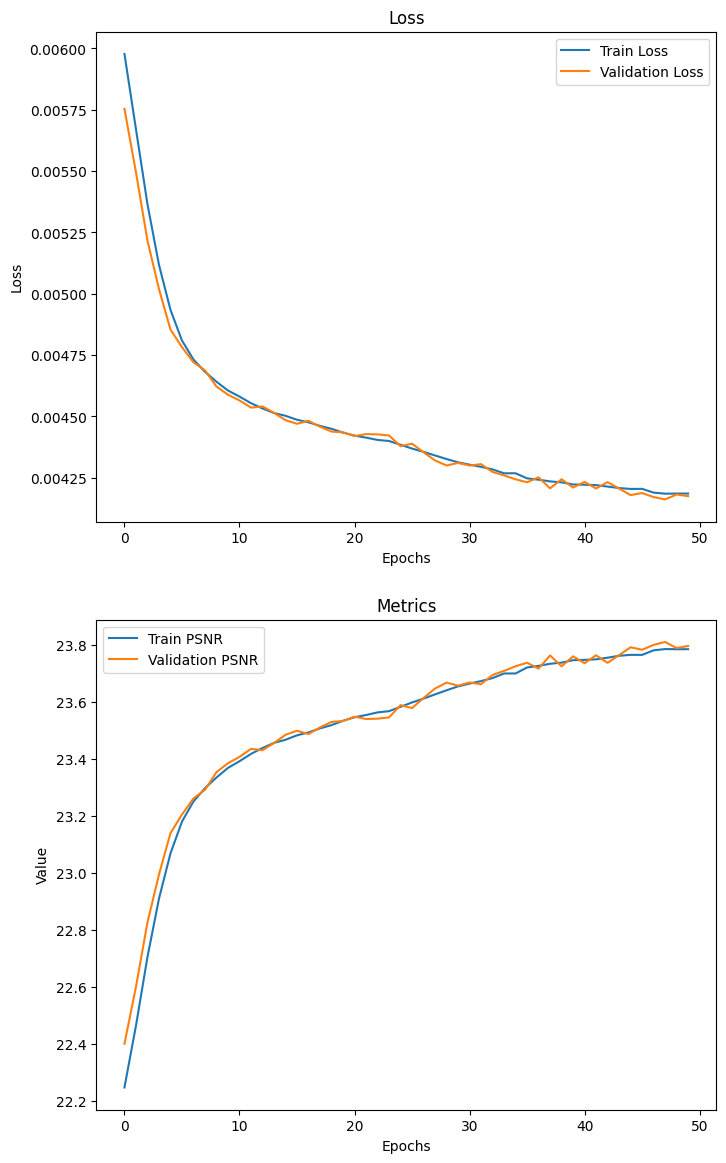

In [11]:
# Построение графиков
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    def plot_metrics(history):
        plt.figure(figsize=(8, 14))
        
        # График ошибки
        plt.subplot(2, 1, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
        # График метрик
        plt.subplot(2, 1, 2)
        plt.plot(history.history['psnr_metric'], label='Train PSNR')
        plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
        plt.title('Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()
        
        plt.show()
    
    # Вызов функции для построения графиков
    plot_metrics(history)